# Wire-up Demo (Config-Driven)
This notebook demonstrates configuration-based loading, graph-building, and argument-driven hooks.

In [1]:
# import importlib
# import src.embeddings
# importlib.reload(src.embeddings)
# import src.fastrp
# importlib.reload(src.fastrp)
# from src.embeddings import node_attribute_embedding, structure_embedding
# from src.fastrp import get_emb_filename, fastrp_wrapper

# # %load_ext autoreload
# # %autoreload 2

In [ ]:
from pathlib import Path
import yaml, sys
import pandas as pd
import matplotlib.pyplot as plt

BASE = Path("..").resolve()
sys.path.append(str(BASE))
CFG = BASE / "config" / "OVTMA_fov216.yaml"


from src.data_io import read_cells_rds, read_roi_labels_csv, read_subject_labels_csv, attach_labels
from src.graph_builder import build_graph
from src.embeddings import node_attribute_embedding, structure_embedding, get_emb_filename
from src.fusion import fuse
from src.aggregation import aggregate
from src.losses import auxiliary_loss
from src.stats import global_celltype_counts, basic_graph_metrics
from src.viz import plot_cells, plot_graph

with open(CFG, "r") as f:
    cfg = yaml.safe_load(f)

cfg


{'paths': {'data_dir': './data/OVTMA_fov216',
  'cell_rds': './data/OVTMA_fov216/cell_level_216fov_forCaitlin_withHLAI.rds',
  'roi_labels_csv': './data/OVTMA_fov216/fov_level_216fov_forCaitlin.csv',
  'subject_labels_csv': './data/OVTMA_fov216/subject_level_216fov_forCaitlin.csv'},
 'cell_columns': {'x': 'x',
  'y': 'y',
  'phenotype': 'metacluster',
  'cell_id': 'tumor_cell_index',
  'roi_id': 'FOV'},
 'roi_label_columns': {'roi_id': 'FOV', 'patient_id': 'Participant'},
 'subject_label_columns': {'patient_id': 'Participant'},
 'graph': {'type': 'gabriel', 'knn_k': 8, 'radius': 25.0},
 'embeddings': {'structure': {'method': 'fastrp',
   'params': {'dim': 64,
    'weights': [1.0, 0.5, 0.25, 0.125],
    'projection_method': 'sparse',
    'input_matrix': 'trans',
    'normalization': False,
    'alpha': None,
    'weight': None,
    'C': 1.0}},
  'node_attributes': {'method': 'passthrough'}},
 'fusion': {'method': 'concat'},
 'aggregation': {'method': 'mean_pool'},
 'auxiliary_loss': {'m

## Load data

In [3]:
paths = cfg['paths']
cols_cell = cfg['cell_columns']
cols_roi = cfg['roi_label_columns']
cols_subj = cfg['subject_label_columns']

# Expect real files per your config; placeholder paths are in config/config.yaml
cells = read_cells_rds(BASE / paths['cell_rds'], cols_cell)
roi_labels = read_roi_labels_csv(BASE / paths['roi_labels_csv'], cols_roi)
subject_labels = read_subject_labels_csv(BASE / paths['subject_labels_csv'], cols_subj)

df = attach_labels(cells, roi_labels, subject_labels)
df.head()

ROI  cell_id phenotype        x       y  n_neighbors  \
0  region_012        1    meta_2  1114.00  150.49          2.0   
1  region_012        2    meta_2   929.83  157.93          1.0   
2  region_012        3    meta_2   849.99  187.98          1.0   
3  region_012        4    meta_2  1270.40  190.82          0.0   
4  region_012        5    meta_2  1302.30  197.60          1.0   

   n_neighbors_meta_1  n_neighbors_meta_2  n_neighbors_meta_3  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 1.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 1.0   

   n_neighbors_meta_4  ...  n_cells_image_meta_10  n_cells_image_meta_2  \
0                 0.0  ...                    165                   327   
1                 0.0  ...                    165                   327   
2                 0.0  ...                    165                   327   
3                 0.0  ...                    165                   327   
4                 0.0  ...                    165                   327   

   n_cells_image_meta_3  n_cells_image_meta_5  n_cells_image_meta_6  \
0                   513                   282                   521   
1                   513                   282                   521   
2                   513                   282                   521   
3                   513                   282                   521   
4                   513                   282                   521   

   n_cells_image_meta_9  n_cells_image_meta_7  n_cells_image_meta_8  \
0                   130                     0                     0   
1                   130                     0                     0   
2                   130                     0                     0   
3                   130                     0                     0   
4                   130                     0                     0   

   n_cells_image_meta_4  histology  
0                     0     Serous  
1                     0     Serous  
2                     0     Serous  
3                     0     Serous  
4                     0     Serous  

[5 rows x 34 columns]

## Visualize cells

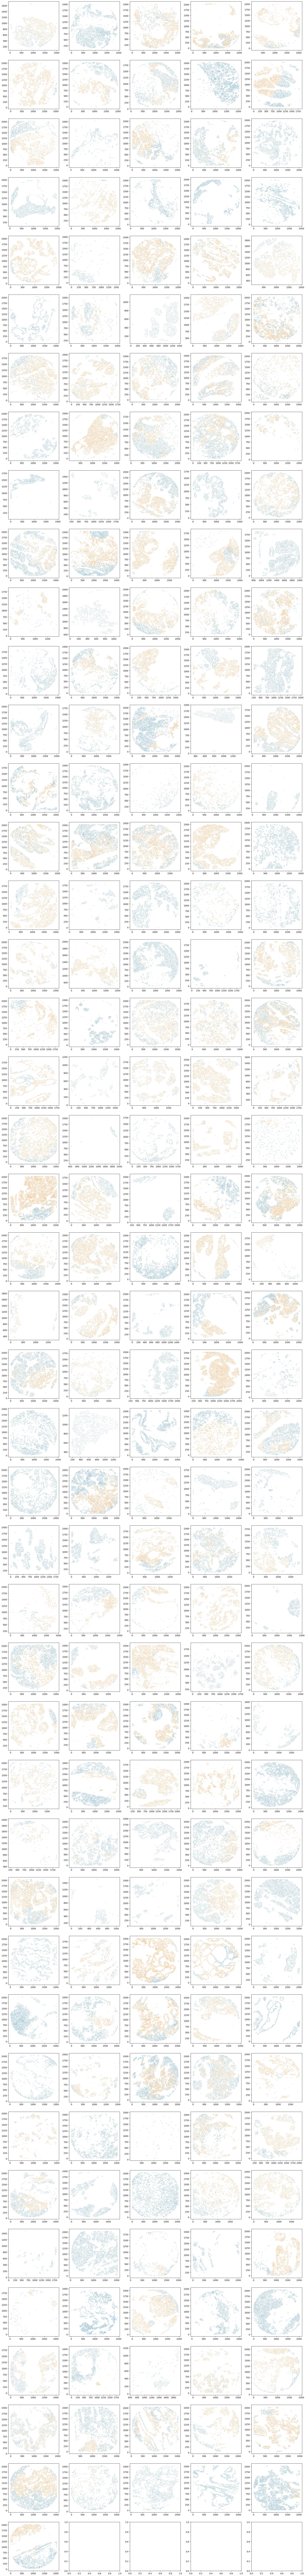

In [30]:
def plot_cells(df: pd.DataFrame, ax=None, s=4, alpha=0.8):
    if ax is None:
        fig, ax = plt.subplots()
    for ct, d in df.groupby("phenotype"):
        ax.scatter(d["x"], d["y"], s=s, alpha=alpha, label=str(ct))
    #ax.set_aspect("equal")
    #ax.legend(title="Phenotype", fontsize=8)
    #ax.set_xlabel("x"); ax.set_ylabel("y")
    return ax
# divide df into each ROI, and plot the cells in each ROI in grid
n_roi = len(df['ROI'].unique())
n_cols = 5
n_rows = n_roi // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 5*n_rows))
for i, roi in enumerate(df['ROI'].unique()):
    ax = axs[i // n_cols, i % n_cols]
    plot_cells(df[df['ROI'] == roi], ax=ax,s=.25)
plt.show()

## Build graph

In [4]:
import networkx as nx
gcfg = cfg['graph']
graph_dict = {}
for roi, df_roi in df.groupby('ROI'):
    G = build_graph(df_roi, kind=gcfg['type'], k=gcfg.get('knn_k', 8), radius=gcfg.get('radius', 25.0))
    basic_graph_metrics(G)
    graph_dict[roi] = G



## Embeddings

### Structure

In [6]:
%%time

import optuna
import networkx as nx
from scipy.io import savemat
import os
from src.fastrp import get_emb_filename
from src.embeddings import structure_embedding, structure_score


scfg = cfg['embeddings']['structure']
method = scfg.get('method')
params = scfg.get('params', {})

prefix_parent = f'../output/OVTMA_fov216/emb'
os.makedirs(prefix_parent, exist_ok=True)
prefix = f'{prefix_parent}/{method}'

order_range = 1

# 1) Build a single graph with disconnected components
G_all = nx.Graph()
for roi, G in graph_dict.items():
    H = nx.relabel_nodes(G, lambda n, r=roi: (r, n))
    G_all.update(H)

# 2)fastRP once (shared projection + scaling)
# Z_struct = structure_embedding(
#     G_all, method, **params)

# 3) for different alpha(beta in paper,tuket parameter), 
# calculate bases A^k*R for k in range(1,order_range)
def objective(trial):
    
    alpha = trial.suggest_float('alpha',-1.0,0.0)
    '''Furthermore, according to the Johnson-Lindenstrauss lemma [12], 
    embedding dimensionality d determines the approximation error of random projection. 
    The implication of this is that we can efficiently tune hyperparameters on smaller values of d.'''
    params['alpha'] = alpha
    params['weights'] = [1] * order_range
    params['return_list'] = True
    basis_list = structure_embedding(G_all, method, **params)

    weights = [trial.suggest_float('weight' + str(order), 1.0, 64.0,log=True) for order in range(order_range)]
    score = structure_score(G_all.nodes(),df,aux='phenotype',weights=weights,basis_list=basis_list)
    return score
study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=20)  # Invoke optimization of the objective function.

[I 2025-09-15 14:46:58,119] A new study created in memory with name: no-name-1a62910e-32f8-4172-a72f-13af569daac9
[W 2025-09-15 15:12:36,532] Trial 0 failed with parameters: {'alpha': -0.8768491934679018, 'weight0': 6.330180020249623} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/yujxiao/miniconda3/envs/tma22/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 43, in objective
  File "/home/yujxiao/TMA22_Sep8_Skeleton/src/embeddings.py", line 166, in structure_score
    y_raw: List[Any] = []
  File "/home/yujxiao/miniconda3/envs/tma22/lib/python3.10/site-packages/pandas/core/ops/common.py", line 76, in new_method
    return method(self, other)
  File "/home/yujxiao/miniconda3/envs/tma22/lib/python3.10/site-packages/pandas/core/arraylike.py", line 40, in __eq__
    return self._cmp_method(other, operator.eq)
  File "/home/yujxiao/miniconda3/e

KeyboardInterrupt: 

### node attribute

In [ ]:


acfg = cfg['embeddings']['node_attributes']
#X_attr = node_attribute_embedding(df, method=acfg.get('method', 'passthrough'), cols=None)


In [11]:
# basic graph metrics
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.density(G_all))


3232
7556
1.621234203588587e-05


### grid search for tuning hyperparameter

In [ ]:
# Assuming you already have:
#   df with columns: ROI, cell_id, phenotype (or your label_col)
#   graph_dict: {roi: nx.Graph with nodes = df[df.ROI==roi]["cell_id"]}

from fastrp_optuna_search import run_two_phase_search, fit_final_classifier

results = run_two_phase_search(
    df=df,
    graph_dict=graph_dict,
    label_col="phenotype",        # change to your label column if different
    coarse_trials=80,             # bump up if you have time
    fine_trials=80,
    n_splits=5,
    active_top_frac=0.25,
    weight_threshold=0.1,
)

print("Active weights (1-based positions):", results["active_weight_positions"])
print("Fine dim grid:", results["dim_grid"])
print("Best coarse:", results["coarse_study"].best_value, results["coarse_study"].best_params)
print("Best fine:", results["fine_study"].best_value, results["fine_study"].best_params)

# Train final model on all nodes with the *fine* best config
X, y, groups, le, clf, best_conf = fit_final_classifier(
    A=results["adjacency"],
    df=df,
    nodelist=results["nodelist"],
    study=results["fine_study"],
    label_col="phenotype",
)
print("Final best fastRP conf:", best_conf)


## Fusion + Aggregation

In [ ]:
fused = fuse(Z_struct, X_attr, method=cfg['fusion']['method'])
graph_vec = aggregate(fused, G, method=cfg['aggregation']['method'])
fused.shape, graph_vec.shape

## Auxiliary loss (placeholder)

In [ ]:
loss = auxiliary_loss(graph_vec, df, **cfg['auxiliary_loss'])
float(loss)

## Stats and a quick plot

In [ ]:
global_celltype_counts(df).head()

In [ ]:
ax = plot_graph(G, df)
plt.show()